In [1]:
#analysis boilerplate imports
import fnal_column_analysis_tools
from fnal_column_analysis_tools.lookup_tools import extractor,evaluator
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray,JaggedTLorentzVectorArray
from fnal_column_analysis_tools.striped import PhysicalColumnGroup,ColumnGroup,jaggedFromColumnGroup
from fnal_column_analysis_tools.jetmet_tools import FactorizedJetCorrector,JetCorrectionUncertainty
from fnal_column_analysis_tools.jetmet_tools import JetResolution,JetResolutionScaleFactor, JetTransformer

import numpy as np
import awkward.numba
from awkward.numba import JaggedArray,Table
from copy import deepcopy
import uproot
import uproot_methods
import time

np.random.seed(12345)

In [2]:
import matplotlib.pyplot as plt
from cycler import cycler

%matplotlib inline
from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot

from dazsle_hbb_recipes.plots.gghbb import hists as gghbb
from dazsle_hbb_recipes.plots.muon_control_region import muon_control_region

plots = hist.Hist("Events / bin",
                  hist.Cat("dataset","Dataset name"),
                  hist.Bin("m_J","Soft-Drop Mass [GeV]",75,50,200),                  
                  hist.Bin("deepDoubleB","Double B-tag Score",25,0,1),
                  hist.Bin("tau21",r"$\tau_{21}$",25,0,1),
                  hist.Bin("tau32",r"$\tau_{32}$",25,0,1)
                 )

pt_plots = hist.Hist("Events / bin",
                  hist.Cat("dataset","Dataset name"),
                  hist.Cat("systematic","JES Systematic"),
                  hist.Bin("pT_J",r"Jet p$_{T}$ [GeV]", 75,200,800),
                  #, weight="weight",
                  )

In [3]:
#histogram display boilerplate
from histbook import Hist, beside, groupby, below
from histbook import bin as hbin
from collections import OrderedDict
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
import histbook as hb
import math

all_hists = OrderedDict()
cat = hb.groupby("category", keeporder=True)

def add_1d(*args):
    h = hb.Hist(hb.bin(*args), cat)
    all_hists[args[0]] = h
    return h

display_opts = {'width': 200, 'height': 200}
def buildDisplay(hists, cols=3):
    rows = []
    for iRow in range(int(math.ceil(len(hists)/cols))+1):
        hrowname = hists.keys()[iRow*cols:(iRow+1)*cols]
        hrow = hists.values()[iRow*cols:(iRow+1)*cols]
        rows.append(hb.beside(*tuple(h.overlay("category").step(n, **display_opts) for h,n in zip(hrow, hrowname))))
    return IPythonDisplay(
        hb.below(*tuple(rows))
    )

In [4]:
#make and fill a histogram of the masses
add_1d("m_J", 75,50,200)#, weight="weight")
add_1d("pT_J_cen", 75,200,800)#, weight="weight")
add_1d("pT_J_jesup", 75,200,800)#, weight="weight")
add_1d("pT_J_jesdown", 75,200,800)#, weight="weight")
add_1d("pT_J_jerup", 75,200,800)#, weight="weight")
add_1d("pT_J_jerdown", 75,200,800)#, weight="weight")
add_1d("deepDoubleB",25,0,1)
add_1d("tau21",25,0,1)
add_1d("tau32",25,0,1)

display = buildDisplay(all_hists,cols=3)

In [5]:
extract = extractor()
correction_data = open("dazsle_corr_files.txt").readlines()
extract.add_weight_sets(correction_data)
jet_energy_corrs = {#AK4
                    '2016MC_AK4JER':['Spring16_25nsV10_MC_PtResolution_AK4PFPuppi'],
                    '2016MC_AK4JERSF':['Spring16_25nsV10_MC_SF_AK4PFPuppi'],
                    '2016MC_AK4JEC':['Summer16_23Sep2016V3_MC_L1FastJet_AK4PFPuppi',
                                     'Summer16_23Sep2016V3_MC_L2Relative_AK4PFPuppi',
                                     'Summer16_23Sep2016V3_MC_L3Absolute_AK4PFPuppi'],
                    '2016MC_AK4JUNC':['Summer16_23Sep2016V3_MC_Uncertainty_AK4PFPuppi'],
                    #AK8
                    '2016MC_AK8JER':['Spring16_25nsV10_MC_PtResolution_AK8PFPuppi'],
                    '2016MC_AK8JERSF':['Spring16_25nsV10_MC_SF_AK8PFPuppi'],
                    '2016MC_AK8JEC':['Summer16_23Sep2016V3_MC_L1FastJet_AK8PFPuppi',
                                     'Summer16_23Sep2016V3_MC_L2Relative_AK8PFPuppi',
                                     'Summer16_23Sep2016V3_MC_L3Absolute_AK8PFPuppi'],
                    '2016MC_AK8JUNC':['Summer16_23Sep2016V3_MC_Uncertainty_AK8PFPuppi'],
                   }
data_corrs = {'2016BCD_AK4JEC':['Summer16_23Sep2016BCDV3_DATA_L1FastJet_AK4PFPuppi',                                   
                                'Summer16_23Sep2016BCDV3_DATA_L2Relative_AK4PFPuppi',
                                'Summer16_23Sep2016BCDV3_DATA_L3Absolute_AK4PFPuppi',
                                'Summer16_23Sep2016BCDV3_DATA_L2L3Residual_AK4PFPuppi'],
              '2016BCD_AK4JUNC':['Summer16_23Sep2016BCDV3_DATA_Uncertainty_AK4PFPuppi'],
              '2016EF_AK4JEC':['Summer16_23Sep2016EFV3_DATA_L1FastJet_AK4PFPuppi',
                               'Summer16_23Sep2016EFV3_DATA_L2Relative_AK4PFPuppi',
                               'Summer16_23Sep2016EFV3_DATA_L3Absolute_AK4PFPuppi',
                               'Summer16_23Sep2016EFV3_DATA_L2L3Residual_AK4PFPuppi'],
              '2016EF_AK4JUNC':['Summer16_23Sep2016EFV3_DATA_Uncertainty_AK4PFPuppi'],
              '2016G_AK4JEC':['Summer16_23Sep2016GV3_DATA_L1FastJet_AK4PFPuppi',                                 
                              'Summer16_23Sep2016GV3_DATA_L2Relative_AK4PFPuppi',
                              'Summer16_23Sep2016GV3_DATA_L3Absolute_AK4PFPuppi',
                              'Summer16_23Sep2016GV3_DATA_L2L3Residual_AK4PFPuppi'],
              '2016G_AK4JUNC':['Summer16_23Sep2016GV3_DATA_Uncertainty_AK4PFPuppi'],
              '2016H_AK4JEC':['Summer16_23Sep2016HV3_DATA_L1FastJet_AK4PFPuppi',                                 
                              'Summer16_23Sep2016HV3_DATA_L2Relative_AK4PFPuppi',
                              'Summer16_23Sep2016HV3_DATA_L3Absolute_AK4PFPuppi',
                              'Summer16_23Sep2016HV3_DATA_L2L3Residual_AK4PFPuppi'],
              '2016H_AK4JUNC':['Summer16_23Sep2016HV3_DATA_Uncertainty_AK4PFPuppi']}

#define the weights we want to keep
keep_weights = ["Rho2D","ZJetsNLO","WJetsNLO",
                "ZJets_012j_NLO/nominal","ZJets_012j_NLO/PDF",
                "ZJets_012j_NLO/fact_up","ZJets_012j_NLO/fact_down",
                "ZJets_012j_NLO/ren_up","ZJets_012j_NLO/ren_down",
                "ZJets_LO/inv_pt","EWKcorr/Z",
                "WJets_012j_NLO/nominal","WJets_012j_NLO/PDF",
                "WJets_012j_NLO/fact_up","WJets_012j_NLO/fact_down",
                "WJets_012j_NLO/ren_up","WJets_012j_NLO/ren_down",
                "WJets_LO/inv_pt","EWKcorr/W",
                "PUWeight2016_central","PUWeight2016_up","PUWeight2016_down",
                "PUWeight2017_central","PUWeight2017_up","PUWeight2017_down",
                "data_obs_muCR4_denominator","data_obs_muCR4_numerator",
                "Mu50_PtEtaBins/efficienciesDATA/pt_abseta_DATA",
                "Mu50_PtEtaBins/efficienciesDATA/pt_abseta_DATA_error",
                "NUM_SoftID_DEN_genTracks/abseta_pt_value","NUM_SoftID_DEN_genTracks/abseta_pt_error",
                "NUM_LooseRelIso_DEN_LooseID/abseta_pt_value","NUM_LooseRelIso_DEN_LooseID/abseta_pt_error",
                "electron_id_EffArea",
                "photon_id_EA_CHad","photon_id_EA_NHad","photon_id_EA_Pho"                
                ]
for key,val in jet_energy_corrs.items():
    keep_weights.extend(val)
extract.finalize(reduce_list=keep_weights)
#make the evaluator
evaluate = extract.make_evaluator()

MC_AK4JEC2016 = FactorizedJetCorrector(**{name:evaluate[name] for name in jet_energy_corrs['2016MC_AK4JEC']})
MC_AK4JER2016 = JetResolution(**{name:evaluate[name] for name in jet_energy_corrs['2016MC_AK4JER']})
MC_AK4JERSF2016 = JetResolutionScaleFactor(**{name:evaluate[name] for name in jet_energy_corrs['2016MC_AK4JERSF']})
MC_AK4JUNC2016 = JetCorrectionUncertainty(**{name:evaluate[name] for name in jet_energy_corrs['2016MC_AK4JUNC']})

mc2016_ak4_jxform = JetTransformer(jec=MC_AK4JEC2016)#,junc=MC_AK4JUNC2016,
                                   #jer=MC_AK4JER2016,jersf=MC_AK4JERSF2016)

MC_AK8JEC2016 = FactorizedJetCorrector(**{name:evaluate[name] for name in jet_energy_corrs['2016MC_AK8JEC']})
MC_AK8JER2016 = JetResolution(**{name:evaluate[name] for name in jet_energy_corrs['2016MC_AK8JER']})
MC_AK8JERSF2016 = JetResolutionScaleFactor(**{name:evaluate[name] for name in jet_energy_corrs['2016MC_AK8JERSF']})
MC_AK8JUNC2016 = JetCorrectionUncertainty(**{name:evaluate[name] for name in jet_energy_corrs['2016MC_AK8JUNC']})

mc2016_ak8_jxform = JetTransformer(jec=MC_AK8JEC2016,junc=MC_AK8JUNC2016,
                                   jer=MC_AK8JER2016,jersf=MC_AK8JERSF2016)
    
#DATA_JEC2016BCD = FactorizedJetCorrector(**{name:evaluate[name] for name in jet_energy_corrs['2016BCD_AK4JEC']})
#DATA_JEC2016EF = FactorizedJetCorrector(**{name:evaluate[name] for name in jet_energy_corrs['2016EF_AK4JEC']})
#DATA_JEC2016G = FactorizedJetCorrector(**{name:evaluate[name] for name in jet_energy_corrs['2016G_AK4JEC']})
#DATA_JEC2016H = FactorizedJetCorrector(**{name:evaluate[name] for name in jet_energy_corrs['2016H_AK4JEC']})
#DATA_JUNC2016BCD = JetCorrectionUncertainty(**{name:evaluate[name] for name in jet_energy_corrs['2016BCD_AK4JUNC']})
#DATA_JUNC2016EF = JetCorrectionUncertainty(**{name:evaluate[name] for name in jet_energy_corrs['2016EF_AK4JUNC']})
#DATA_JUNC2016G = JetCorrectionUncertainty(**{name:evaluate[name] for name in jet_energy_corrs['2016G_AK4JUNC']})
#DATA_JUNC2016H = JetCorrectionUncertainty(**{name:evaluate[name] for name in jet_energy_corrs['2016H_AK4JUNC']})

#print MC_AK8JEC2016
#print MC_AK8JER2016
#print MC_AK8JERSF2016
#print MC_AK8JUNC2016


In [6]:
#build a string of "OR" for list of triggers from json bits file
import json
def selectTriggers(imap,triggerMap):
    if not imap =={}:
        version     = imap['version']
        hltNames    = imap['names']
        branchName  = imap['branchName'] #triggerBits or moreTriggerBits
        #validate input
        if version in triggerMap:
            NameToBitMap = triggerMap[version]
        else:
            print "ERROR! Cannot find triggerbit map of the requested bit version =%s. Possible versions are: %s"%(version, ",".join(triggerMap.keys()))
        tCuts = []
        for hltName in hltNames:
            print hltName
            if hltName in NameToBitMap:
                bitValue = int(NameToBitMap[hltName])
                tCuts.append("(%s[:,%s])"%(branchName,bitValue))
            else:
                print "ERROR! Cannot find the TriggerBit for %s"%hltName 
        print "Using trigger bits = ","|".join(tCuts) 
        return "|".join(tCuts) 
    else:
        return "1"

triggerBitMaps = json.load(open("data/ggH/TriggerBitMap.json"))

triggerNames = {"version":"zprimebit-12.07-triggerBits","branchName":"triggerBits",
                "names":[
                         "HLT_AK8PFJet330_PFAK8BTagCSV_p17_v*",
                         "HLT_PFHT1050_v*",
                         "HLT_AK8PFJet400_TrimMass30_v*",
                         "HLT_AK8PFHT800_TrimMass50_v*",
                         "HLT_PFJet500_v*",
                         "HLT_AK8PFJet360_TrimMass30_v*",
                         "HLT_AK8PFJet380_TrimMass30_v*",
                         "HLT_AK8PFJet500_v*"]
                }

triggerCutString = selectTriggers(triggerNames,triggerBitMaps)
triggerCut = lambda triggerBits : eval(triggerCutString)
if not triggerNames=={}:
    print "List of OR Triggers : ",triggerNames['names']
    print "Using trigger cuts  : ",triggerCutString

HLT_AK8PFJet330_PFAK8BTagCSV_p17_v*
HLT_PFHT1050_v*
HLT_AK8PFJet400_TrimMass30_v*
HLT_AK8PFHT800_TrimMass50_v*
HLT_PFJet500_v*
HLT_AK8PFJet360_TrimMass30_v*
HLT_AK8PFJet380_TrimMass30_v*
HLT_AK8PFJet500_v*
Using trigger bits =  (triggerBits[:,15])|(triggerBits[:,27])|(triggerBits[:,12])|(triggerBits[:,13])|(triggerBits[:,14])|(triggerBits[:,4])|(triggerBits[:,24])|(triggerBits[:,21])
List of OR Triggers :  ['HLT_AK8PFJet330_PFAK8BTagCSV_p17_v*', 'HLT_PFHT1050_v*', 'HLT_AK8PFJet400_TrimMass30_v*', 'HLT_AK8PFHT800_TrimMass50_v*', 'HLT_PFJet500_v*', 'HLT_AK8PFJet360_TrimMass30_v*', 'HLT_AK8PFJet380_TrimMass30_v*', 'HLT_AK8PFJet500_v*']
Using trigger cuts  :  (triggerBits[:,15])|(triggerBits[:,27])|(triggerBits[:,12])|(triggerBits[:,13])|(triggerBits[:,14])|(triggerBits[:,4])|(triggerBits[:,24])|(triggerBits[:,21])


In [7]:
#trigger eff scale factors
from dazsle_hbb_recipes.weights import hackEvaluatorForVTrigSF,VtrigSF
hackEvaluatorForVTrigSF(evaluate)

#muon selection scale factors
from dazsle_hbb_recipes.weights import MuonIDSF,MuonIsoSF,MuonTrigSF

#WJetsQQ and ZJetsQQ kfactors
from dazsle_hbb_recipes.kfactors import hackEvaluatorForVJetsQQ_2016, getKFactor2016, getKFactor2017
hackEvaluatorForVJetsQQ_2016(evaluate)

#PUPPI soft-drop mass correction
from dazsle_hbb_recipes.weights import PUPPIweight

/anaconda2/lib/python2.7/site-packages/dazsle_hbb_recipes-0.0.1-py2.7.egg/dazsle_hbb_recipes/weights/trigger_sf.py:17: RuntimeWarning: invalid value encountered in divide


In [8]:
#electron IDs
from dazsle_hbb_recipes.ids import calcElectronEffAreaIso,passEleVetoSel,passEleLooseSel,\
                                   passEleMediumSel,passEleTightSel,passEleHEEPSel

#muon IDs
from dazsle_hbb_recipes.ids import calcMuonDeltaBetaIso,passMuonLooseSel,passMuonMediumSel,\
                                   passMuonTightSel,passHighPtMuonSel

#tau IDs
from dazsle_hbb_recipes.ids import passTauSel

#photon IDs
from dazsle_hbb_recipes.ids import calcPhotonEffAreaIso,passPhoLooseSel,passPhoMediumSel,passPhoTightSel

#btag working points
from dazsle_hbb_recipes.ids import CSV_Loose,CSV_Medium,CSV_Tight

#jet selections
from dazsle_hbb_recipes.ids import passLooseJetSel,passJetTightLepVetoSel
from dazsle_hbb_recipes.ids import selectVetoMuons,selectVetoElectrons,selectVetoPhotons,selectVetoTaus

In [9]:
#matching functions
def matchByDPhi(first,second,deltaPhiCut=2./3.*math.pi):
    args = first.phi._argcross(second.phi)
    argsnested = JaggedArray.fromcounts(first.phi.counts, 
                                        JaggedArray.fromcounts(first.phi._broadcast(second.phi.counts).flatten(), 
                                                               args._content))
    phi0s  = first.phi.content[argsnested.content.content.i0]
    phi1s  = second.phi.content[argsnested.content.content.i1]
    offsets_outer = argsnested.offsets
    offsets_inner = argsnested.content.offsets
    dphis = (phi0s - phi1s + math.pi) % (2*math.pi) - math.pi
    passdphi = (np.abs(dphis) < deltaPhiCut)
    passdphi = JaggedArray.fromoffsets(offsets_inner,passdphi)
    return JaggedArray.fromoffsets(offsets_outer,passdphi.any())

def antiMatchByDR(first,second,deltaRCut=0.8):
    drCut2 = deltaRCut**2
    args = first.eta._argcross(second.eta)
    argsnested = JaggedArray.fromcounts(first.eta.counts, 
                                        JaggedArray.fromcounts(first.eta._broadcast(second.eta.counts).flatten(), 
                                                               args._content))
    eta0s  = first.eta.content[argsnested.content.content.i0]
    eta1s  = second.eta.content[argsnested.content.content.i1]
    phi0s  = first.phi.content[argsnested.content.content.i0]
    phi1s  = second.phi.content[argsnested.content.content.i1]
    offsets_outer = argsnested.offsets
    offsets_inner = argsnested.content.offsets
    detas = np.abs(eta0s - eta1s)
    dphis = (phi0s - phi1s + math.pi) % (2*math.pi) - math.pi
    passdr = ((detas**2 + dphis**2) > drCut2)
    passdr = JaggedArray.fromoffsets(offsets_inner,passdr)
    return JaggedArray.fromoffsets(offsets_outer,passdr.any())

In [10]:
#gen history operations
from dazsle_hbb_recipes.gentools import getParentsOfType,getParentsOfTypeFlat,hasParentOfType,\
                                        getChildrenOfType,getHighestPtBoson,parseGeneratorHistory,\
                                        activePdgIds,activePdgIdLabels

In [11]:
#analysis cut defaults
class analysis_cuts:
    PTCUT = 350.#450.
    PTCUTMUCR = 300.#400.
    DBTAGCUT = 0.90
    DBTAGCUTMIN = -99.
    T21DDTCUT = 0.55
    MUONPTCUT = 55
    METCUT = 140
    MASSCUT = 40
    NJETCUT = 100
    b_tagger_name = 'deepcsvb'
    
gghbbcuts = analysis_cuts()

In [12]:
from pyinstrument import Profiler

profiler = Profiler()

extracting 107 columns
[ 6.6399226 15.617403   2.2271824 ... 31.464518  38.824516  42.66131  ]


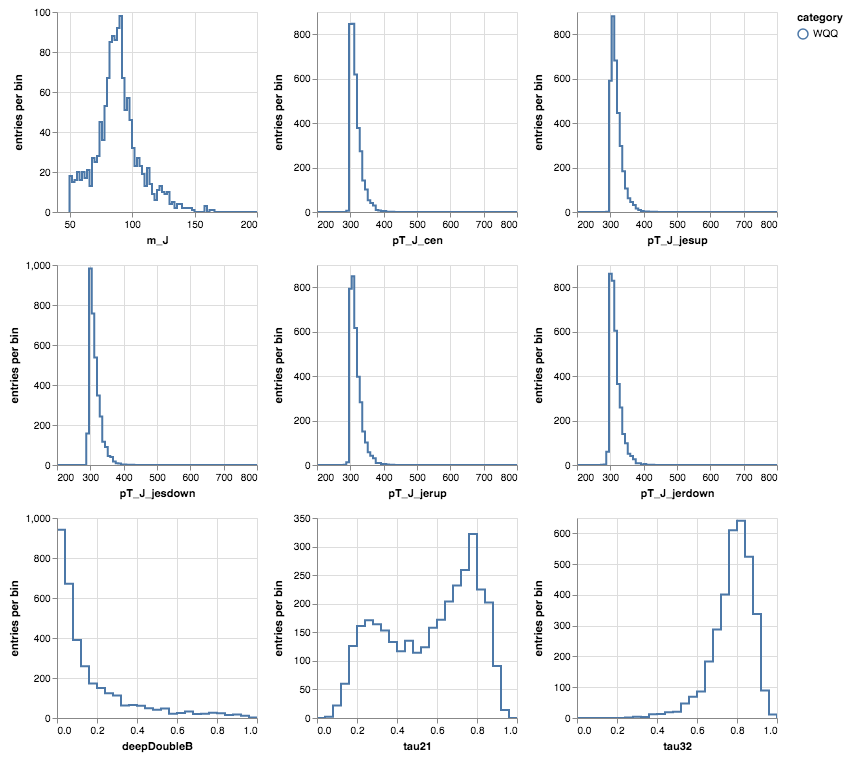

[59.451515  24.799229  60.460102  ... 69.222496  22.453703   2.9987595]


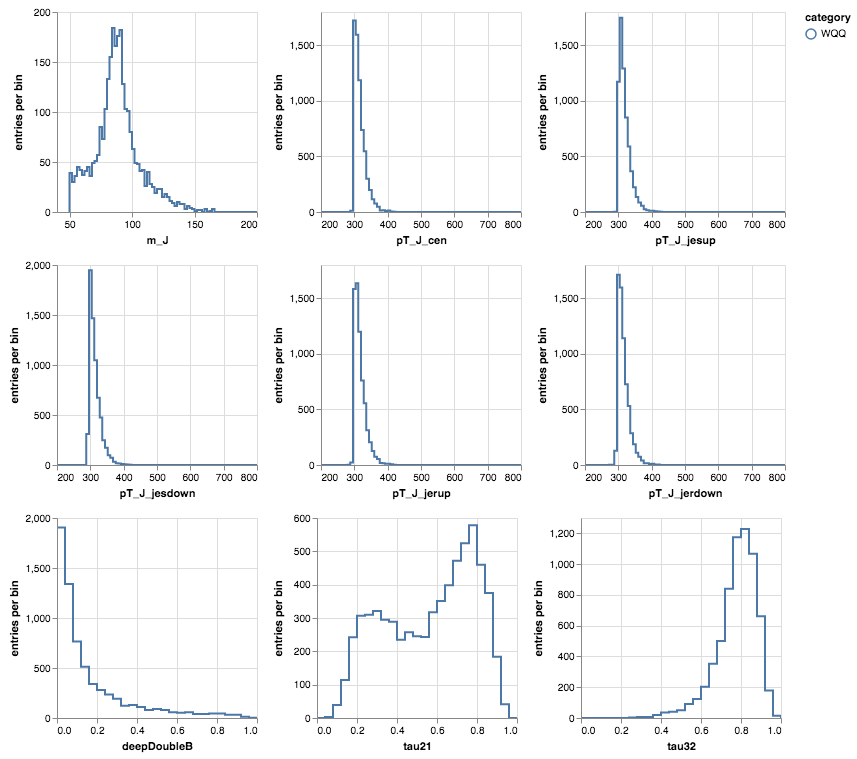

[44.533936 25.526428 38.071198 ... 44.219196 78.982544 11.067259]


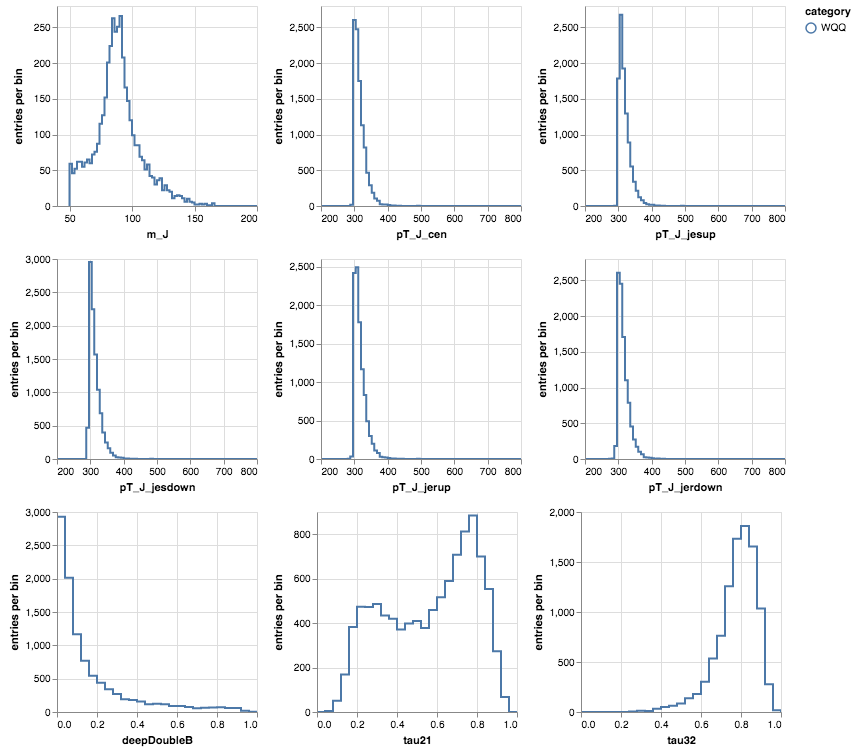

[ 39.365902  67.552635  38.711525 ...  20.885767 125.573074  40.31254 ]


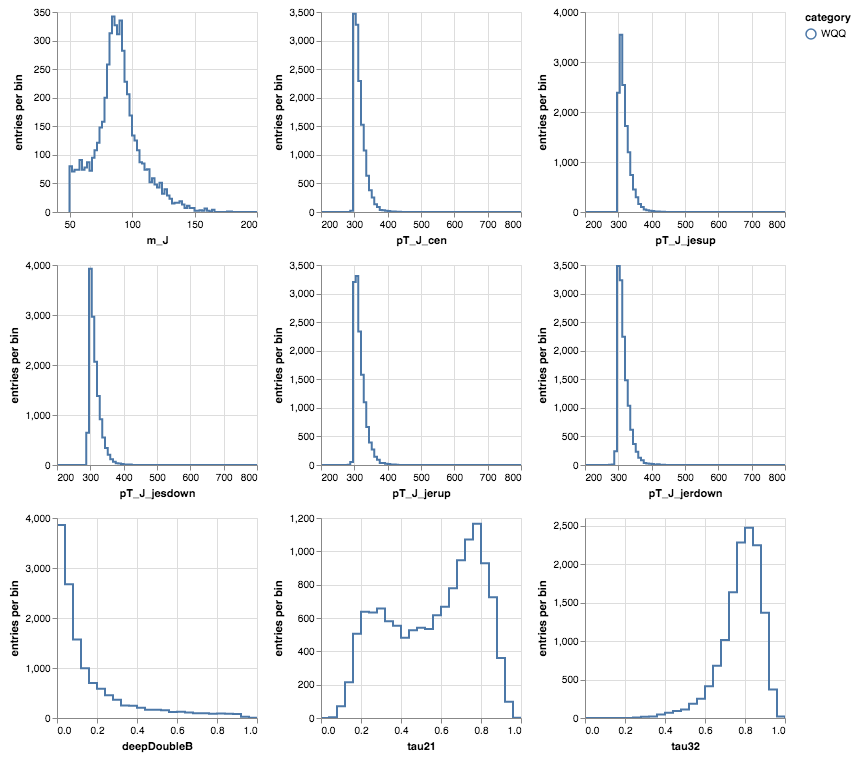

[ 57.093155 130.07837   27.291763 ...  25.253876  22.909689  35.13188 ]


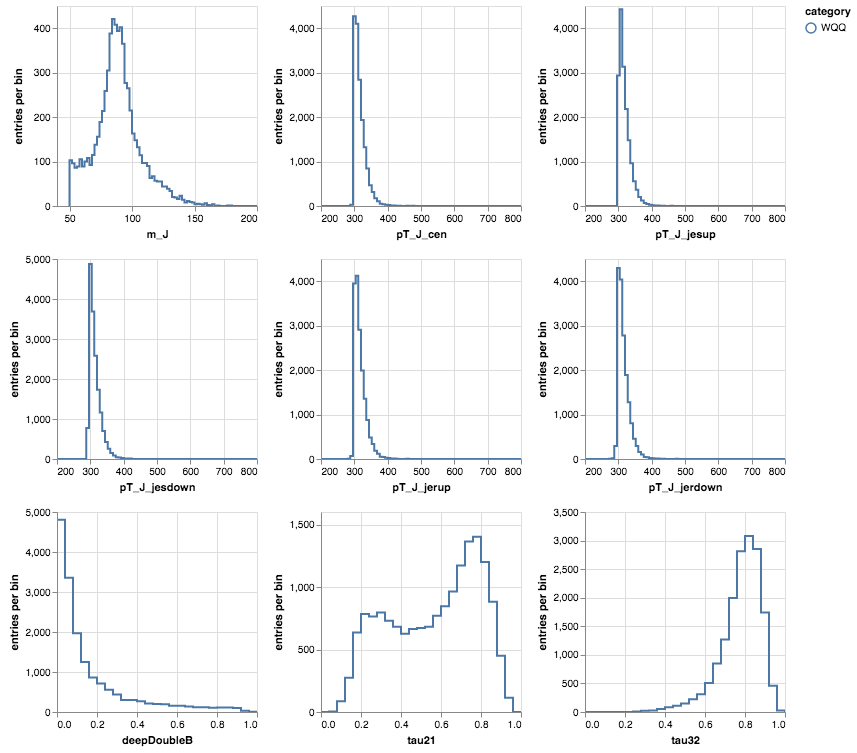

[19.81709  58.46526  68.09095  ... 26.664268 45.176773 58.544422]


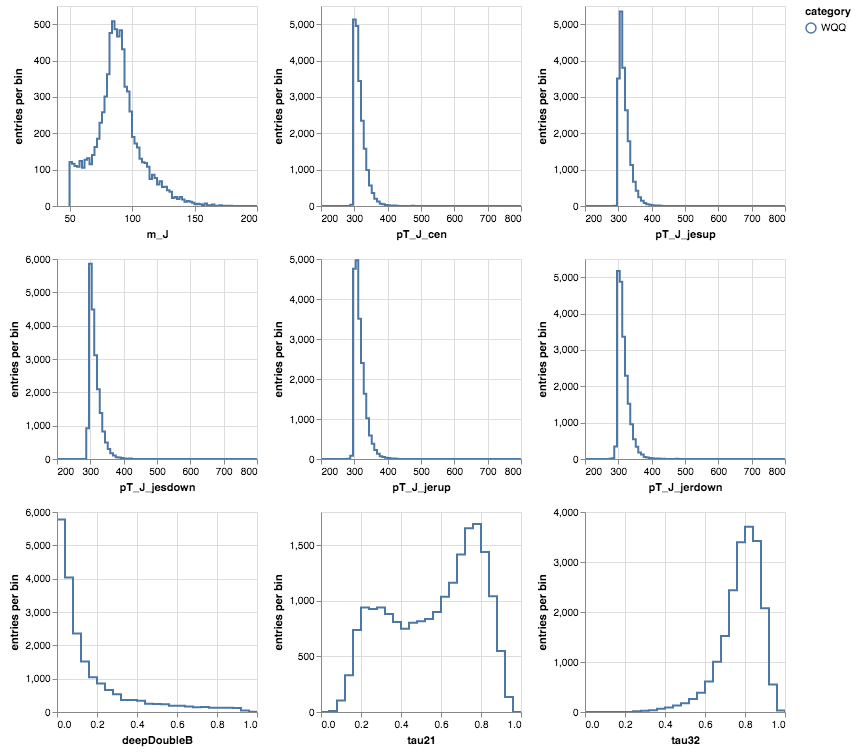

[37.795433 32.484528 69.97753  ... 10.454887 40.863895 34.278706]


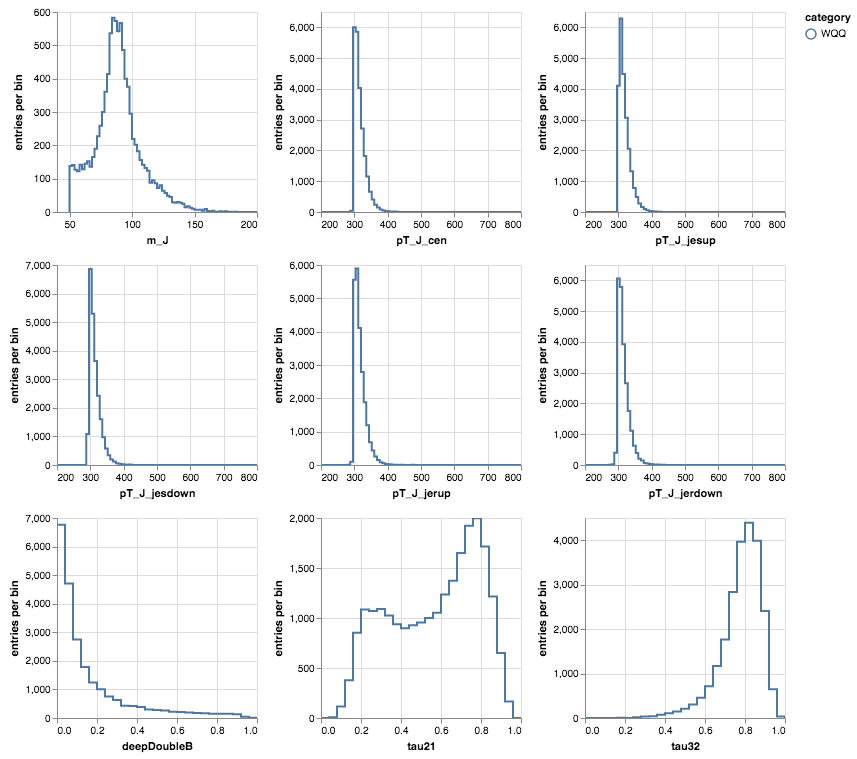

[12.900591 31.699617 23.82833  ... 45.265198 30.37593  40.17738 ]


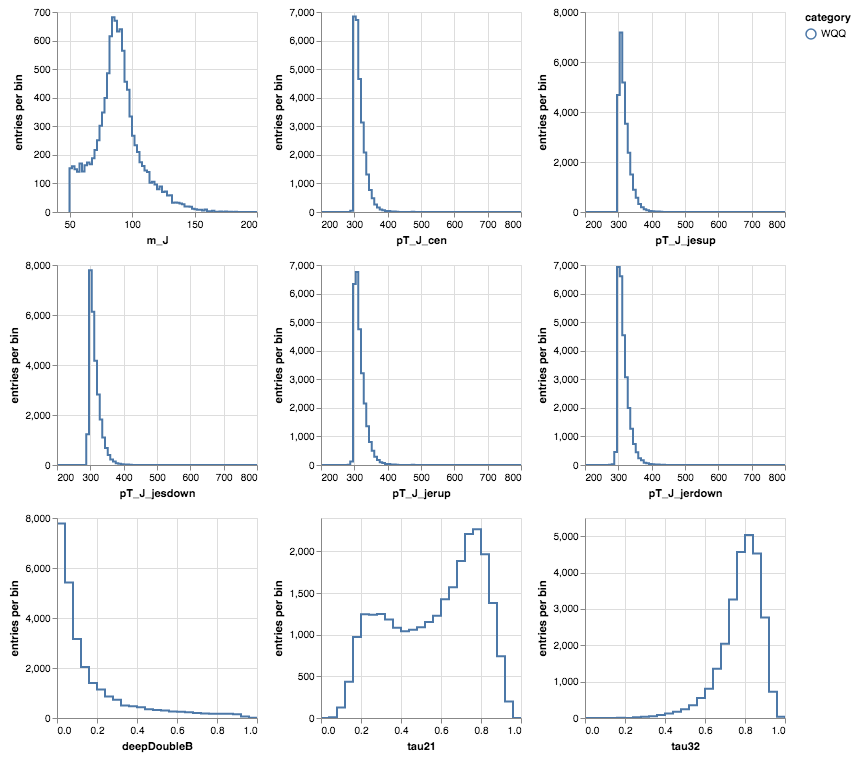

[27.014338 23.400497 48.1756   ... 35.05601  43.768734 27.887386]


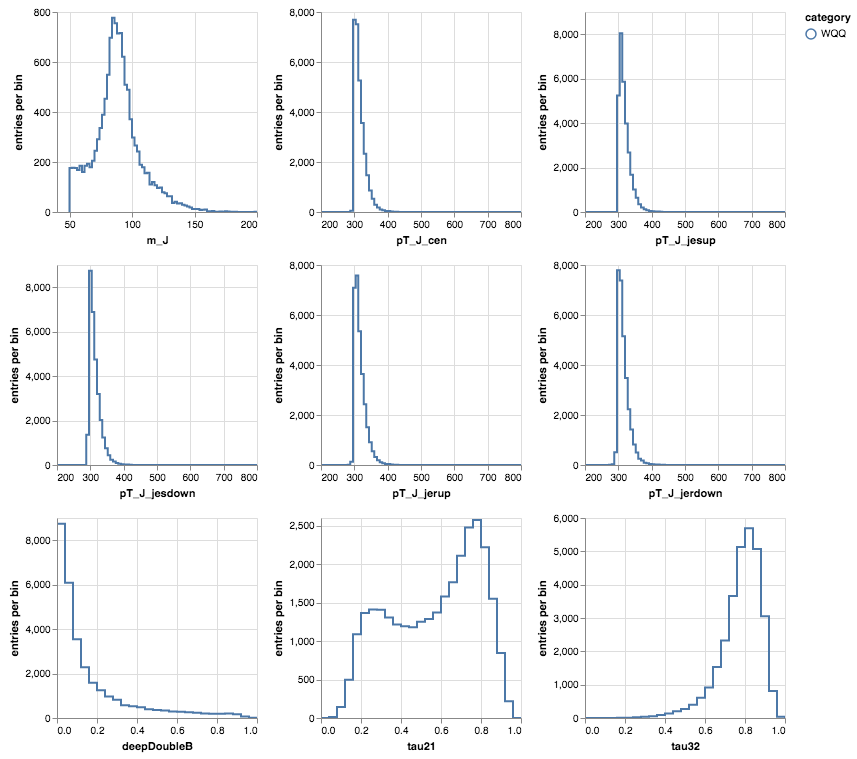

[31.203007  9.175082 31.330027 ... 19.404963 66.68031  65.92956 ]


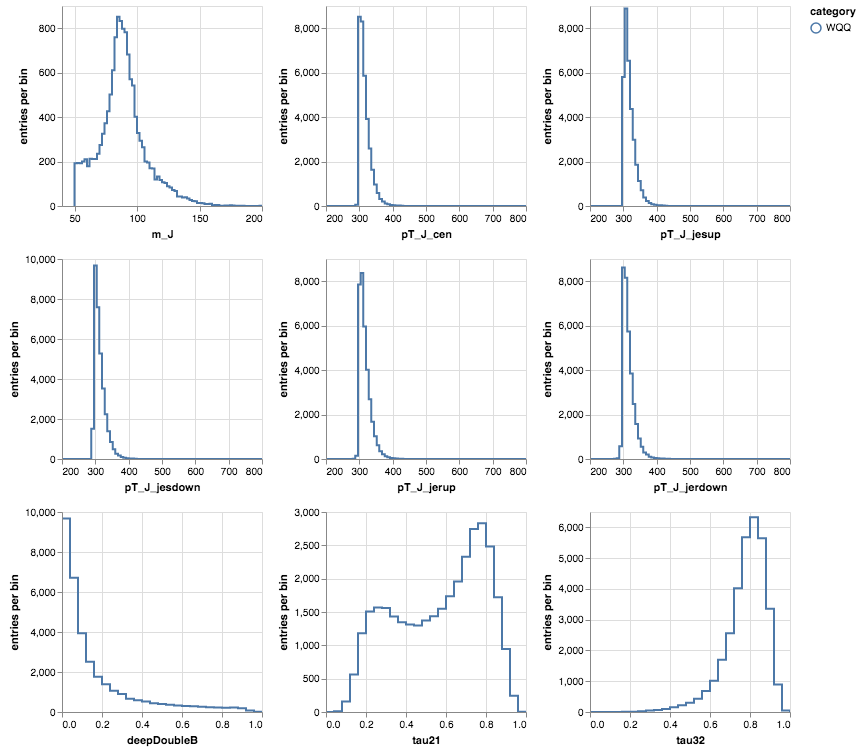

[41.78017  15.366055 14.512389 ... 13.805995 25.456186 47.296898]


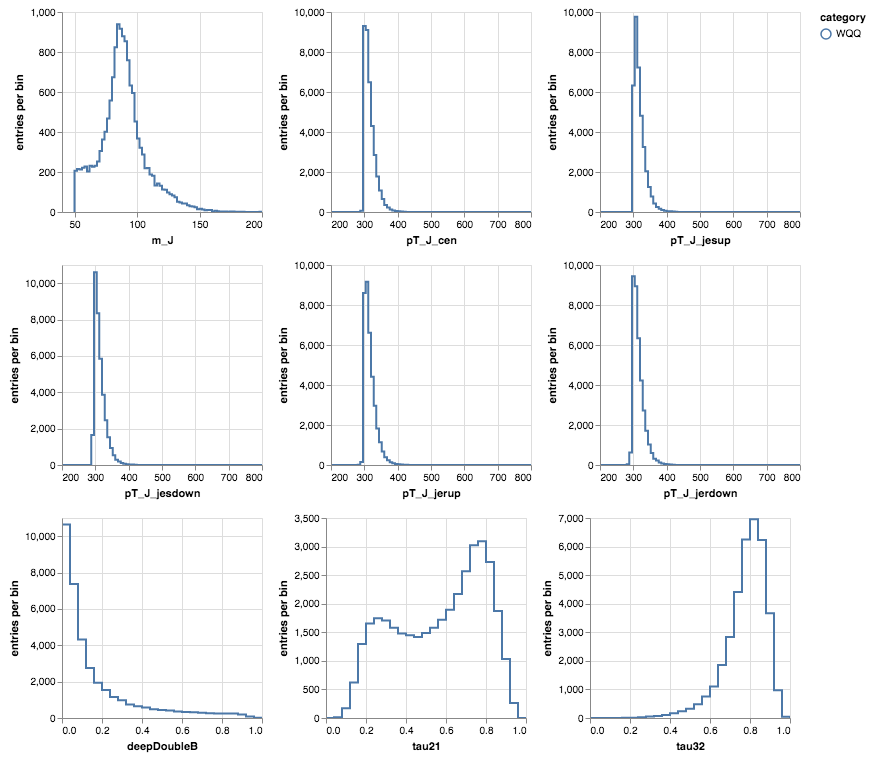

[27.729536 31.698378 39.40448  ... 30.161415 42.146893 21.884155]


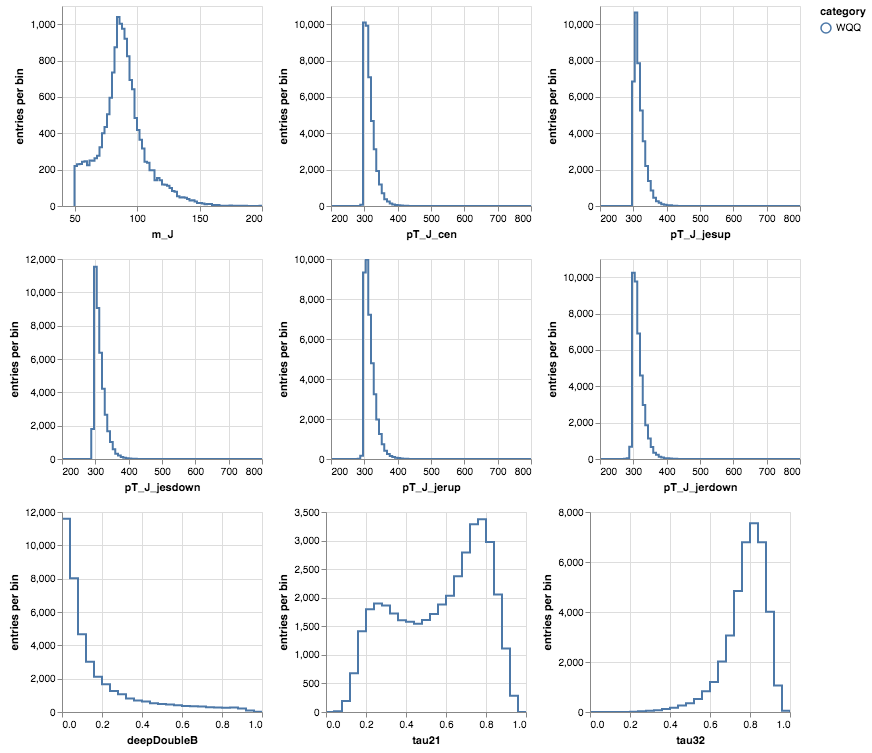

[37.25191  48.67827  28.657417 ... 41.58587  34.772114 26.219135]


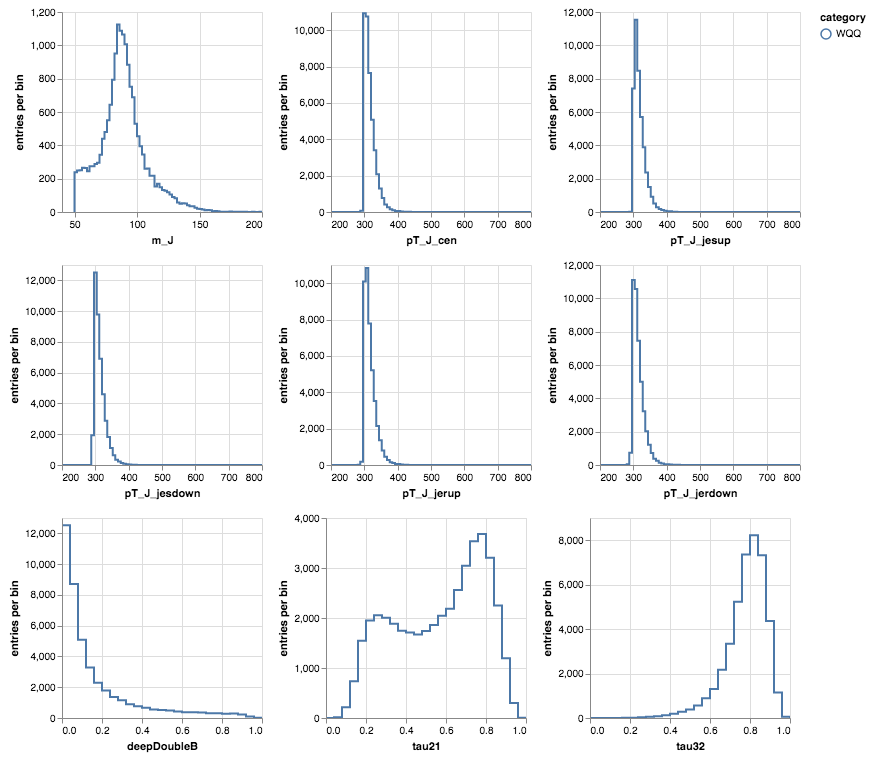

[59.534836 20.093782 39.752354 ... 31.214003 26.449415 36.417477]


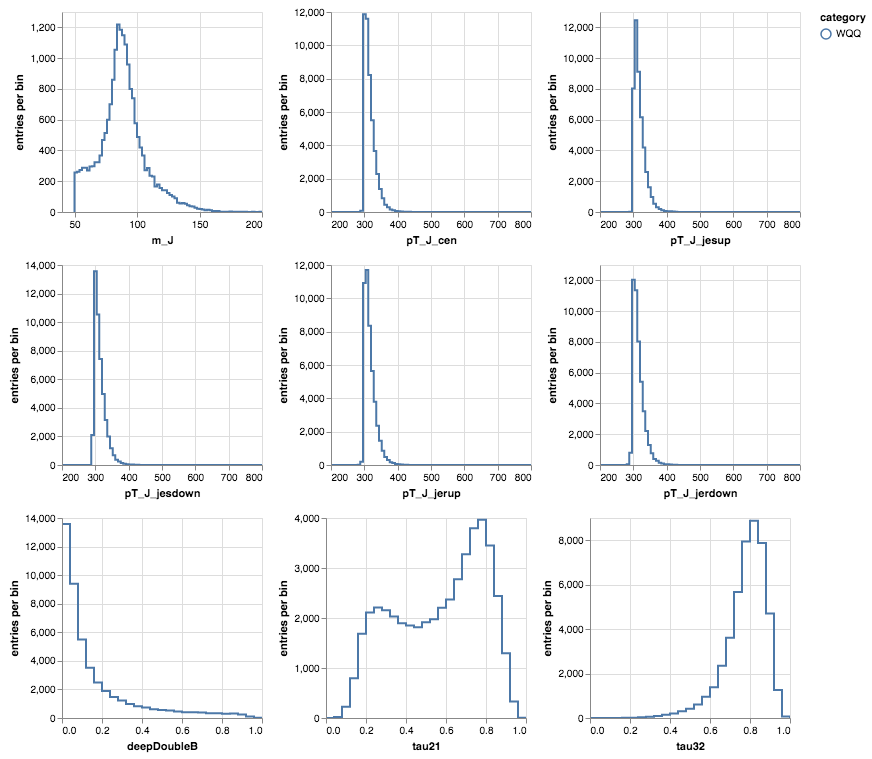

[72.466484 31.683746 26.679956 ... 17.444416 65.983116 55.490295]


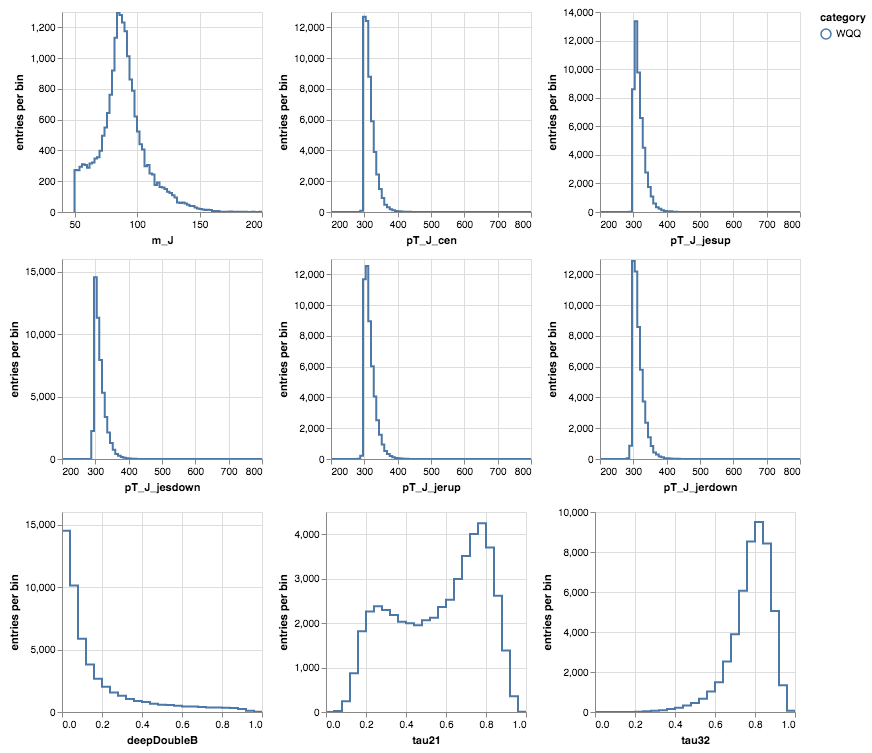

[51.70621  94.487495 54.80302  ... 13.681471 21.635529 37.454506]


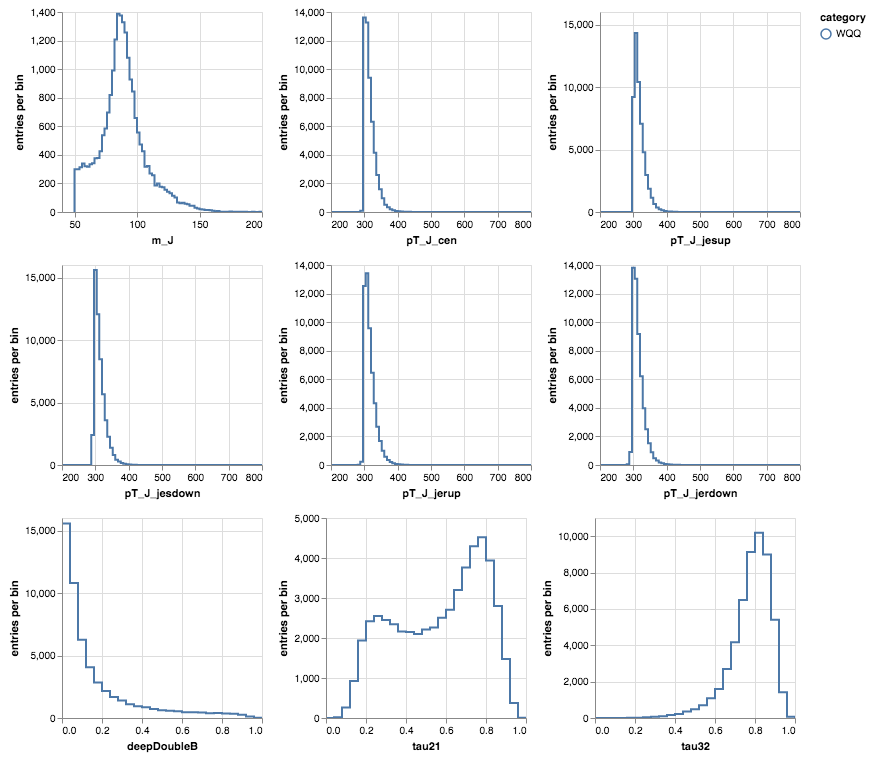

[38.691933 34.17751  24.960247 ... 75.652664 50.788643 76.11322 ]


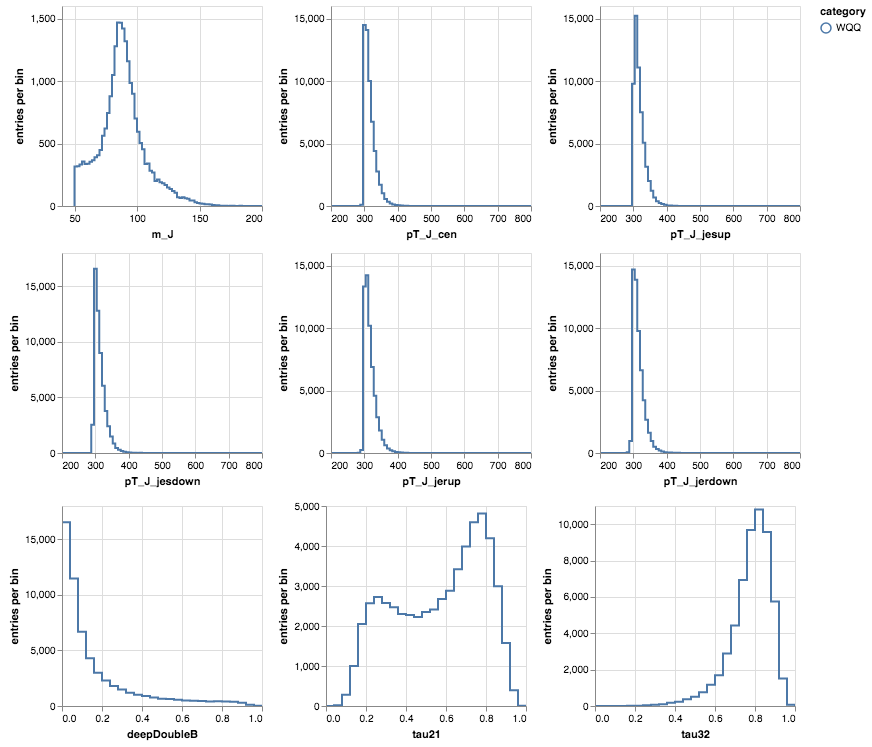

[14.319431  91.50311   32.052647  ... 51.347607   5.5575914 50.22276  ]


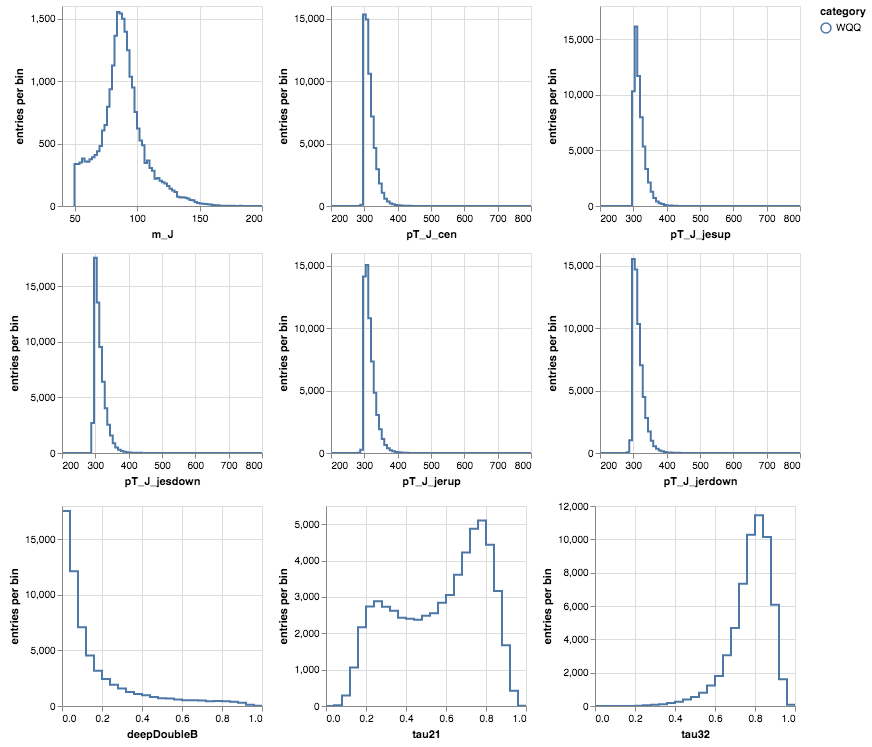

[ 9.7992   39.93877  45.261013 ... 44.53557  71.71026  31.369713]


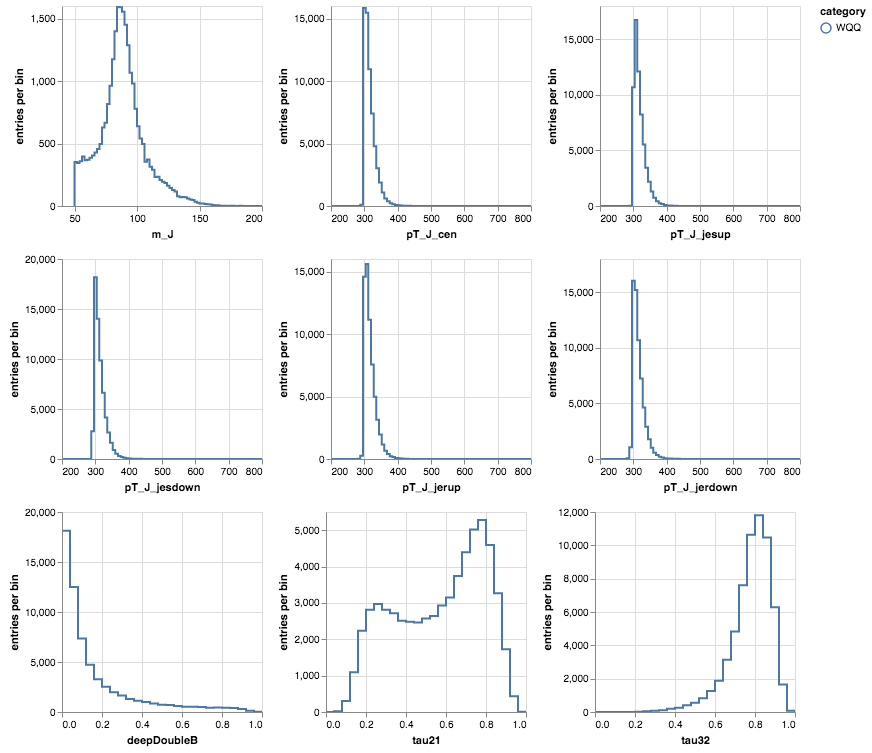

In [13]:
import concurrent.futures
import multiprocessing
thread_mult = 4
thread_pool = concurrent.futures.ThreadPoolExecutor(thread_mult*multiprocessing.cpu_count())

outer_tic = time.time()

display.init()
_ = map(lambda h: h.clear(), all_hists.values())

filestr = "/Users/lagray/coffea/bacon_prod/WJetsToQQ_HT400to600_qc19_3j_TuneCP5_13TeV.root"

trgColumns = {}#{'triggerBits':'triggerBits'}

evtColumns = {'pfmet':'pfMETC','pfmetphi':'pfMETCphi','puppet':'puppETC',
              'puppetphi':'puppETCphi','npu':'nPU','rhoIso':'rhoIso','rhoJet':'rhoJet'}

genPcolumns = {'pt':'GenParticle.pt','eta':'GenParticle.eta','phi':'GenParticle.phi','mass':'GenParticle.mass', 
               'parent':'GenParticle.parent','pdgId':'GenParticle.pdgId','status':'GenParticle.status',                
               'rapidity':'GenParticle.y'}

ak8columns = {'pt':'AK8Puppi.pt','eta':'AK8Puppi.eta','phi':'AK8Puppi.phi','mass':'AK8Puppi.mass',
              'area':'AK8Puppi.area','ptRaw':'AK8Puppi.ptRaw',
              'deepcsvb':'AddAK8Puppi.doublecsv','msd':'AddAK8Puppi.mass_sd0','deepdoubleb':'AddAK8Puppi.deepdoubleb',
              'deepdoubleb_nomasssculptpen':'AddAK8Puppi.deepdoubleb_nomasssculptpen','tau1':'AddAK8Puppi.tau1',
              'tau2':'AddAK8Puppi.tau2','tau3':'AddAK8Puppi.tau3','e3_v2_sdb1':'AddAK8Puppi.e3_v2_sdb1',
              'e2_sdb1':'AddAK8Puppi.e2_sdb1',
              'genpt':'AK8Puppi.genpt','geneta':'AK8Puppi.geneta','genphi':'AK8Puppi.genphi',
              'genmass':'AK8Puppi.genm',
              'neuHadFrac':'AK8Puppi.neuHadFrac','neuEmFrac':'AK8Puppi.neuEmFrac','nParticles':'AK8Puppi.nParticles',
              'muonFrac':'AK8Puppi.muonFrac','chHadFrac':'AK8Puppi.chHadFrac','nCharged':'AK8Puppi.nCharged',
              'nNeutrals':'AK8Puppi.nNeutrals','chEmFrac':'AK8Puppi.chEmFrac'}

ak4columns = {'pt':'AK4Puppi.pt','eta':'AK4Puppi.eta','phi':'AK4Puppi.phi','mass':'AK4Puppi.mass',
              'qgid':'AK4Puppi.qgid','csv':'AK4Puppi.csv','area':'AK4Puppi.area','ptRaw':'AK4Puppi.ptRaw',
              'genpt':'AK4Puppi.genpt','geneta':'AK4Puppi.geneta','genphi':'AK4Puppi.genphi',
              'genmass':'AK4Puppi.genm',
              'neuHadFrac':'AK4Puppi.neuHadFrac','neuEmFrac':'AK4Puppi.neuEmFrac','nParticles':'AK4Puppi.nParticles',
              'muonFrac':'AK4Puppi.muonFrac','chHadFrac':'AK4Puppi.chHadFrac','nCharged':'AK4Puppi.nCharged',
              'nNeutrals':'AK4Puppi.nNeutrals','chEmFrac':'AK4Puppi.chEmFrac'}

muoncolumns = {'pt':'Muon.pt','eta':'Muon.eta','phi':'Muon.phi','pogIDBits':'Muon.pogIDBits',
               'chHadIso':'Muon.chHadIso','neuHadIso':'Muon.neuHadIso','gammaIso':'Muon.gammaIso',
               'puIso':'Muon.puIso'}

electroncolumns = {'pt':'Electron.pt','eta':'Electron.eta','phi':'Electron.phi',
                   'typeBits':'Electron.typeBits','chHadIso':'Electron.chHadIso',
                   'neuHadIso':'Electron.neuHadIso','gammaIso':'Electron.gammaIso',
                   'sieie':'Electron.sieie','hovere':'Electron.hovere','eoverp':'Electron.eoverp',
                   'nMissingHits':'Electron.nMissingHits','ecalEnergy':'Electron.ecalEnergy',
                   'dEtaInSeed':'Electron.dEtaInSeed','dPhiIn':'Electron.dPhiIn','d0':'Electron.d0',
                   'trkIso':'Electron.trkIso','hcalDepth1Iso':'Electron.hcalDepth1Iso',
                   'e2x5':'Electron.e2x5','e1x5':'Electron.e1x5','e5x5':'Electron.e5x5',
                   'isConv':'Electron.isConv','scEta':'Electron.scEta'}

taucolumns = {'pt':'Tau.pt','eta':'Tau.eta','phi':'Tau.phi','mass':'Tau.m',
              'hpsDisc':'Tau.hpsDisc','rawIso3Hits':'Tau.rawIso3Hits'}

photoncolumns = {'pt':'Photon.pt','eta':'Photon.eta','phi':'Photon.phi','scEta':'Photon.scEta',
                 'chHadIso':'Photon.chHadIso','neuHadIso':'Photon.neuHadIso','gammaIso':'Photon.gammaIso',
                 'hovere':'Photon.hovere','sieie':'Photon.sieie'}

all_columns = [trgColumns,evtColumns,genPcolumns,ak8columns,ak4columns,
               muoncolumns,electroncolumns,taucolumns,photoncolumns]

columns = []

jet_systs = {"central":"",
             "jes_up":"jes_up","jes_down":"jes_down",
             "jer_up":"jer_up","jer_down":"jer_down"}

muon_systs = {"central":"",
              "mutrig_up":"trig_up","mutrig_down":"trig_down",
              "muid_up":"id_up"    ,"muid_down":"id_down",
              "muiso_up":"iso_up"  ,"muiso_down":"iso_down",
              "mupu_up":"pu_up"    ,"mupu_down":"pu_down"}

for cols in all_columns: columns.extend(list(cols.values()))

print 'extracting',len(columns),'columns'
    
issim = True
globalScaling = 1.0
fbWeight = 1.0
datasetName = "WJetsToQQ_HT400to600_qc19_3j_TuneCP5_13TeV"

# 0 = get highest pT boson
# 1 = get last boson in modification chain
genVlookupType = {'ZJets':(23,0),
                  'WJets':(24,1),                  
                  'Higgs':(25,1),
                  'Exotica':(55,1),                  
                 }

tot_events = 0
tot_time = 0.0
for arrays in uproot.iterate(filestr,'Events',columns,entrysteps=100000,executor=thread_pool,awkwardlib=awkward.numba):
    tic = time.time()
    #profiler.start()
    #triggers can be special, need to reshape
    #triggerInfo = arrays[trgColumns['triggerBits']]
    #triggerInfo = JaggedArray.fromcounts(triggerInfo.counts*256,triggerInfo.content.flatten())
        
    #event-level info (run / evt / met / etc)    
    eventInfo = JaggedArray.fromcounts(np.ones_like(arrays[evtColumns['pfmet']],dtype=np.int),
                                       Table({key:arrays[val] for key,val in evtColumns.items()}))
    
    #pileup weights (first for 2016)
    evtNpu = eventInfo['npu']
    puweight,puweight_up,puweight_down = 1.0,1.0,1.0
    if issim:
        puweight = evaluate["PUWeight2016_central"](evtNpu)
        puweight_up = evaluate["PUWeight2016_up"](evtNpu)
        puweight_down = evaluate["PUWeight2016_down"](evtNpu) 
    else:
        puweight = evtNpu.ones_like()
        puweight_up = evtNpu.ones_like()
        puweight_down = evtNpu.ones_like()
    
    vjetsKF_central = 1.0
    if issim:
        #gen particle info
        genParticles = JaggedCandidateArray.candidatesfromcounts(arrays[genPcolumns['pt']].counts,
                                                                 **{key:arrays[val].content for key,val in genPcolumns.items()})
        vPdgId,lookupType = 0,-1
        if 'WJets' in datasetName: 
            vPdgId,lookupType = genVlookupType['WJets']
        elif 'ZJets' in datasetName or 'DYJets' in datasetName:
            vPdgId,lookupType = genVlookupType['ZJets']
        elif 'HToBB' in datasetName or 'HToCC' in datasetName:
            vPdgId,lookupType = genVlookupType['Higgs']
        elif 'Spin0' in datasetName or 'VectorDiJet' in datasetName:
            vPdgId,lookupType = genVlookupType['Exotica']
    
        argV = evtNpu.zeros_like() #set to the protons as default    
        if lookupType == 0:
            argV = getHighestPtBoson(genParticles.pdgId,genParticles.pt,vPdgId)
        elif lookupType == 1:
            ## this is very ugly we should fix it
            profiler.start()
            argV = getParentsOfType(genParticles.parent,genParticles.pdgId,vPdgId,True).astype(dtype=np.float).max().astype(dtype=np.int)
            profiler.stop()
            argV = JaggedArray.fromcounts(np.ones(argV.size,dtype=np.int),argV)

        genVs = genParticles[argV]
                
        vjetsKF = getKFactor2016(datasetName,evaluate,genVs.pt)
        vjetsKF_central = vjetsKF["central"].content
            
    #setup muon candidates (gotta spoof the mass :-/)
    muonarrays = {key:arrays[val].content for key,val in muoncolumns.items()}
    muonmasses = np.full_like(muonarrays['pt'],0.1056583745)
    muonarrays['mass'] = muonmasses
    muons = JaggedCandidateArray.candidatesfromcounts(arrays[muoncolumns['pt']].counts,
                                                      **muonarrays)
    #add muon trigger, loose-id, and iso scale factors and variations
    muidweight,muidweight_up,muidweight_down       = 1.0,1.0,1.0
    muisoweight,muisoweight_up,muisoweight_down    = 1.0,1.0,1.0
    mutrigweight,mutrigweight_up,mutrigweight_down = 1.0,1.0,1.0
    if issim:
        muidweight,muidweight_up,muidweight_down       = MuonIDSF(evaluate,muons.pt,muons.eta)
        muisoweight,muisoweight_up,muisoweight_down    = MuonIsoSF(evaluate,muons.pt,muons.eta)
        mutrigweight,mutrigweight_up,mutrigweight_down = MuonTrigSF(evaluate,muons.pt,muons.eta)
    else:
        muidweight,muidweight_up,muidweight_down       = muons.pt.ones_like(),muons.pt.ones_like(),muons.pt.ones_like()
        muisoweight,muisoweight_up,muisoweight_down    = muons.pt.ones_like(),muons.pt.ones_like(),muons.pt.ones_like()
        mutrigweight,mutrigweight_up,mutrigweight_down = muons.pt.ones_like(),muons.pt.ones_like(),muons.pt.ones_like()
    
    weight_mu_base = puweight.content * fbWeight * globalScaling * vjetsKF_central
    weight_mu_base_up = puweight_up.content * fbWeight * globalScaling * vjetsKF_central
    weight_mu_base_down = puweight_down.content * fbWeight * globalScaling * vjetsKF_central
    
    mu_sfweight_central = mutrigweight * muidweight * muisoweight
    
    weight_mu = weight_mu_base * mu_sfweight_central
    weight_mutrig_up = weight_mu_base * mutrigweight_up * muidweight * muisoweight
    weight_mutrig_down = weight_mu_base * mutrigweight_down * muidweight * muisoweight
    
    weight_muid_up = weight_mu_base * mutrigweight * muidweight_up * muisoweight
    weight_muid_down = weight_mu_base * mutrigweight * muidweight_down * muisoweight
    
    weight_muiso_up = weight_mu_base * mutrigweight * muidweight * muisoweight_up
    weight_muiso_down = weight_mu_base * mutrigweight * muidweight * muisoweight_down
    
    weight_mupu_up = weight_mu_base_up * mu_sfweight_central
    weight_mupu_down = weight_mu_base_down * mu_sfweight_central
    
    muons.add_attributes(deltaBetaIso = calcMuonDeltaBetaIso(muons),
                         weight_mu = weight_mu,
                         weight_mutrig_up = weight_mutrig_up,
                         weight_mutrig_down = weight_mutrig_down,
                         weight_muid_up = weight_muid_up,
                         weight_muid_down = weight_muid_down,
                         weight_muiso_up = weight_muiso_up,
                         weight_muiso_down = weight_muiso_down,
                         weight_mupu_up = weight_mupu_up,
                         weight_mupu_down = weight_mupu_down,)
    
    #various types of muon we'll need
    vetoMuons = muons[selectVetoMuons(muons)]

    passLooseMuonId = passMuonLooseSel(muons)
    looseMuons = muons[passLooseMuonId]
    leadingLooseMuon = looseMuons[looseMuons.pt.argmax()]
    
    #setup electrons candidates (gotta spoof the mass :-/)
    electronarrays = {key:arrays[val].content for key,val in electroncolumns.items()}
    electronmasses = np.full_like(electronarrays['pt'],0.000511)
    electronarrays['mass'] = electronmasses
    electrons = JaggedCandidateArray.candidatesfromcounts(arrays[electroncolumns['pt']].counts,
                                                          **electronarrays)
    el_abseta = np.abs(electrons.eta)
    electrons.add_attributes(absEta  = el_abseta,
                             EffArea = evaluate['electron_id_EffArea'](el_abseta))
    electrons.add_attributes(effAreaIso = calcElectronEffAreaIso(electrons,eventInfo['rhoIso']))
    
    #various types of electrons we'll need
    vetoElectrons = electrons[selectVetoElectrons(electrons)]
    
    passLooseElectronId = passEleLooseSel(electrons)
    looseElectrons = electrons[passLooseElectronId]
    
    #setup tau candidates    
    taus = JaggedCandidateArray.candidatesfromcounts(arrays[taucolumns['pt']].counts,
                                                     **{key:arrays[val].content for key,val in taucolumns.items()})
    #various types of taus we'll need
    #vetoTaus = taus[selectVetoTaus(taus,vetoMuons,vetoElectrons)]
    
    passLooseTauId = passTauSel(taus)
    looseTaus = taus[passLooseTauId]    
    
    #setup photon candidates (gotta spoof the mass :-/)
    photonarrays = {key:arrays[val].content for key,val in photoncolumns.items()}
    photonmasses = np.full_like(photonarrays['pt'],0.0)
    photonarrays['mass'] = photonmasses
    photons = JaggedCandidateArray.candidatesfromcounts(arrays[photoncolumns['pt']].counts,
                                                        **photonarrays)
    ph_absSCeta  = np.abs(photons.scEta)
    EA_CHad = evaluate['photon_id_EA_CHad'](ph_absSCeta)
    EA_NHad = evaluate['photon_id_EA_NHad'](ph_absSCeta)
    EA_Pho  = evaluate['photon_id_EA_Pho'](ph_absSCeta)    
    photons.add_attributes(absSCEta  = ph_absSCeta,
                           EA_CHad = EA_CHad,
                           EA_NHad = EA_NHad,
                           EA_Pho  = EA_Pho)
    photonIsoInfo = calcPhotonEffAreaIso(photons,eventInfo['rhoIso'])
    photons.add_attributes(chIsoCorr  = photonIsoInfo[0],
                           nhIsoCorr  = photonIsoInfo[1],
                           gamIsoCorr = photonIsoInfo[2],
                           neuIsoLooseMax  = photonIsoInfo[3],
                           neuIsoMediumMax  = photonIsoInfo[4],
                           neuIsoTightMax  = photonIsoInfo[5])
    
    vetoPhotons = photons[selectVetoPhotons(photons,vetoElectrons)]
    
    #setup ak8 jet candidates
    ## setup the raw values we need to apply JECs   
    ak8columns['massRaw'] = 'AK8Puppi.massRaw'
    ak8columns['rho'] = 'AK8Puppi.rho'    
    ak8_unjec = arrays[ak8columns['ptRaw']]/arrays[ak8columns['pt']]
    arrays[ak8columns['massRaw']] = ak8_unjec*arrays[ak8columns['mass']]
    arrays[ak8columns['rho']] = eventInfo['rhoJet'].content*ak8_unjec.ones_like()
    
    ak8puppijet = JaggedCandidateArray.candidatesfromcounts(arrays[ak8columns['pt']].counts,
                                                            **{key:arrays[val].content for key,val in ak8columns.items()})
    #apply jecs and update the jet
    mc2016_ak8_jxform.transform(ak8puppijet)
    
    msd_corr_8 = ak8puppijet.msd*PUPPIweight(ak8puppijet.pt,ak8puppijet.eta)
    clamped_msd_corr_8 = np.maximum(msd_corr_8,0.01) 
    
    rh_8 = 2.0*(np.log(clamped_msd_corr_8) - np.log(ak8puppijet.pt))  # tocheck here
    rhP_8 = 2.0*np.log(clamped_msd_corr_8) - np.log(ak8puppijet.pt)
    jtau21_8 = ak8puppijet.tau2/(ak8puppijet.tau1 + 1e-8)
    jt21P_8 = jtau21_8 + 0.063 * rhP_8
    N2sdb1=ak8puppijet.e3_v2_sdb1/(ak8puppijet.e2_sdb1**2 + 1e-8)
    jtN2b1sdddt_8 = N2sdb1 - evaluate['Rho2D'](rh_8,ak8puppijet.pt)
    #trigger weights for the Vs
    trigweight,trigweight_up,trigweight_down = VtrigSF(evaluate,ak8puppijet.msd,ak8puppijet.pt)
    #create AK8 jet weights before selection
    puweight_temp = fbWeight * globalScaling * puweight.content
    puweight_temp_up = fbWeight * globalScaling * puweight_up.content
    puweight_temp_down = fbWeight * globalScaling * puweight_down.content
    trigweight_temp = vjetsKF_central * trigweight
    trigweight_up_temp = vjetsKF_central * trigweight_up
    trigweight_down_temp = vjetsKF_central * trigweight_down
    weight = puweight_temp * trigweight_temp    
    weight_trigger_up = puweight_temp * trigweight_up_temp
    weight_trigger_down = puweight_temp *  trigweight_down_temp
    weight_pu_up = puweight_temp_up * trigweight_temp
    weight_pu_down = puweight_temp_down * trigweight_temp
    #store all our calculated stuff
    ak8puppijet.add_attributes(jdb_8 = getattr(ak8puppijet,gghbbcuts.b_tagger_name),
                               msd_corr_8=msd_corr_8,
                               rh_8=rh_8,
                               rhP_8=rhP_8,
                               tau21=jtau21_8,
                               tau32=ak8puppijet.tau3/(ak8puppijet.tau2 + 1e-8),
                               jt21P_8=jt21P_8,
                               N2sdb1=N2sdb1,
                               jtN2b1sdddt_8=jtN2b1sdddt_8,
                               weight=weight,
                               weight_trigger_up=weight_trigger_up,
                               weight_trigger_down=weight_trigger_down,
                               weight_pu_up=weight_pu_up,
                               weight_pu_down=weight_pu_down)
    ak8puppijet_pt200 = ak8puppijet[passLooseJetSel(ak8puppijet) & 
                                    (ak8puppijet.pt > 200) & 
                                    (np.abs(ak8puppijet.eta) < 2.5)]
    
    ak8veto = ~( ak8puppijet_pt200.fastmatch(vetoMuons,deltaRCut=0.4) | 
                 ak8puppijet_pt200.fastmatch(vetoElectrons,deltaRCut=0.4) |
                 ak8puppijet_pt200.fastmatch(vetoPhotons,deltaRCut=0.4) )
    
    ak8jets_veto = ak8puppijet_pt200[ak8veto]
    
    leadingak8jet = ak8jets_veto[ak8jets_veto.pt.argmax()]
    
    #setup ak4 jet candidates
    ## first calculate JECs from raw pts and energies
    ak4columns['massRaw'] = 'AK4Puppi.massRaw'
    ak4columns['rho'] = 'AK4Puppi.rho'    
    ak4_unjec = arrays[ak4columns['ptRaw']]/arrays[ak4columns['pt']]
    arrays[ak4columns['massRaw']] = ak4_unjec*arrays[ak4columns['mass']]
    arrays[ak4columns['rho']] = eventInfo['rhoJet'].content*ak4_unjec.ones_like()
                
    ak4puppijet = JaggedCandidateArray.candidatesfromcounts(arrays[ak4columns['pt']].counts,
                                                            **{key:arrays[val].content for key,val in ak4columns.items()})
    #apply jecs and update the jet
    mc2016_ak4_jxform.transform(ak4puppijet)
    
    #apply basic selections
    ak4puppijet_pt30 = ak4puppijet[ passLooseJetSel(ak4puppijet) & 
                                    (ak4puppijet.pt > 30) ]
    ak4jets_in_tracker = np.abs(ak4puppijet.eta) < 2.5
    
    ak4veto = ~( ak4puppijet_pt30.fastmatch(vetoMuons,deltaRCut=0.4) | 
                 ak4puppijet_pt30.fastmatch(vetoElectrons,deltaRCut=0.4) |
                 ak4puppijet_pt30.fastmatch(vetoPhotons,deltaRCut=0.4) ) 
    
    ak4_hasLbtag = CSV_Loose(ak4puppijet_pt30)
    ak4_hasMbtag = CSV_Medium(ak4puppijet_pt30)
    ak4_hasTbtag = CSV_Tight(ak4puppijet_pt30)
    ak4_goodjets = ak4puppijet_pt30[ak4veto]
    ak4_Mbtags  = ak4puppijet_pt30[ak4_hasMbtag & ak4veto & ak4jets_in_tracker]
    ak4_Lbtags = ak4puppijet_pt30[ak4_hasLbtag & ak4veto & ak4jets_in_tracker]
    ak4_Tbtags = ak4puppijet_pt30[ak4_hasTbtag & ak4veto & ak4jets_in_tracker]
    
    #for VBF tag (aka quark jet in sample container)
    AK4jet_AK8jet_matches = ak4_goodjets.fastmatch(leadingak8jet)
    unmatched_ak4 = ak4_goodjets[~AK4jet_AK8jet_matches]
    vbf_ak4_pairs = unmatched_ak4.p4.distincts(nested=True)
    vbf_ak4_detas = np.abs(qgl_ak4_pairs.i0.eta - qgl_ak4_pairs.i1.eta).flatten()
    vbf_ak4_maxdetas = qgl_ak4_detas.argmax()
    vbf_ak4_masses = (qgl_ak4_pairs.i0 + qgl_ak4_pairs.i1).mass.flatten()[qgl_ak4_maxdetas]
    vbf_ak4_pass = ( qgl_ak4_detas[qgl_ak4_maxdetas] > 3.25 ) & ( qgl_ak4_masses > 975.0 )
    
    # -> trigger selection done but very few pass
    presel = ( ( ((leadingak8jet.pt > gghbbcuts.PTCUTMUCR).sum() > 0) | 
                 ((leadingak8jet.pt_jes_up > gghbbcuts.PTCUTMUCR).sum() > 0) | 
                 ((leadingak8jet.pt_jes_down > gghbbcuts.PTCUTMUCR).sum() > 0) |
                 ((leadingak8jet.pt_jer_up > gghbbcuts.PTCUTMUCR).sum() > 0) |
                 ((leadingak8jet.pt_jer_down > gghbbcuts.PTCUTMUCR).sum() > 0) ) 
                #& triggerCut(triggerInfo)
             ) 
    #presel = ( ( ak8puppijet.counts > 0 ) & ( ak8puppijet.tau21 < T21DDTCUT) )
    
    hasTightVJet = (passJetTightLepVetoSel(leadingak8jet).sum() > 0)
    
    signal_region = ( #jet selection
                      ((leadingak8jet.pt > gghbbcuts.PTCUT).sum() > 0) &
                      ((leadingak8jet.msd_corr_8 > gghbbcuts.MASSCUT).sum() > 0) &
                      ((leadingak8jet.jtN2b1sdddt_8 < 0).sum() > 0) &
                      hasTightVJet &
                      #met selection (remove events with large MET, fake or real)
                      (eventInfo['pfmet'].sum() < gghbbcuts.METCUT) & 
                      #lepton vetos
                      (looseMuons.counts == 0) &
                      (looseElectrons.counts == 0) &
                      (looseTaus.counts == 0)                    
                    )
    
    #single muon control region
    #matching criteria for control regions
    AK8jet_muon_matches = leadingak8jet.fastmatch(leadingLooseMuon,matchfunc=matchByDPhi)        
    AK8jet_AK4Lbjet_antimatches = leadingak8jet.fastmatch(ak4_Lbtags,matchfunc=antiMatchByDR)
    AK8jet_AK4Mbjet_antimatches = leadingak8jet.fastmatch(ak4_Mbtags,matchfunc=antiMatchByDR)
    AK8jet_AK4Tbjet_antimatches = leadingak8jet.fastmatch(ak4_Tbtags,matchfunc=antiMatchByDR)
    singlemuon_cr = ( #jet selection
                      ((leadingak8jet.pt > gghbbcuts.PTCUTMUCR).sum() > 0) &
                      ((leadingak8jet.msd_corr_8 > gghbbcuts.MASSCUT).sum() > 0) &
                      hasTightVJet &
                      #muon selection
                      ((np.abs(leadingLooseMuon.eta) < 2.1).sum() > 0) &
                      ((leadingLooseMuon.pt > gghbbcuts.MUONPTCUT).sum() > 0) &
                      #matches and cross cleaning
                      (AK8jet_muon_matches.sum() == 0) &                      
                      (AK8jet_AK4Mbjet_antimatches.sum() > 0) &
                      #lepton vetos
                      (looseMuons.counts == 1) &
                      (looseElectrons.counts == 0) &
                      (looseTaus.counts == 0)
                    )
    
    # signal region objects and plots
    mask_sr = presel & signal_region    
    pvs_sr = evtNpu[mask_sr]
    ak8jets_sr = leadingak8jet[mask_sr]
    met_sr = eventInfo['pfmet'][mask_sr]    
    
    # muon control region objects and plots
    mask_mucr = presel & singlemuon_cr
    pvs_mucr = evtNpu[mask_mucr]
    muons_mucr = looseMuons[mask_mucr]
    ak4jets_mucr = ak4puppijet_pt30[mask_mucr]
    ak8jets_mucr = leadingak8jet[mask_mucr]
    met_mucr = eventInfo['pfmet'][mask_mucr]    
    
    # muon_control_region(gghbbcuts, singlemuon_cr, looseMuons, ak4puppijet_pt30, leadingak8jet, gghbb,)    
    
    selected_ak8 = leadingak8jet[presel & signal_region]
    selected_pvs = evtNpu[presel]
    
    #fill histograms
    all_hists['m_J'].fill(category='WQQ',m_J=selected_ak8.msd_corr_8.max())
    all_hists['pT_J_cen'].fill(category='WQQ',pT_J_cen=selected_ak8.pt.max())
    all_hists['pT_J_jesup'].fill(category='WQQ',pT_J_jesup=selected_ak8.pt_jes_up.max())
    all_hists['pT_J_jesdown'].fill(category='WQQ',pT_J_jesdown=selected_ak8.pt_jes_down.max())
    all_hists['pT_J_jerup'].fill(category='WQQ',pT_J_jerup=selected_ak8.pt_jer_up.max())
    all_hists['pT_J_jerdown'].fill(category='WQQ',pT_J_jerdown=selected_ak8.pt_jer_down.max())
    all_hists['deepDoubleB'].fill(category='WQQ',deepDoubleB=selected_ak8.deepdoubleb.flatten())
    all_hists['tau21'].fill(category='WQQ',tau21=selected_ak8.tau21.flatten())
    all_hists['tau32'].fill(category='WQQ',tau32=selected_ak8.tau32.flatten())
    
    gghbb['nPV'].fill(dataset="WQQ",npv=selected_pvs.flatten(),weight=selected_ak8.weight.flatten())
    
    plots.fill(
        dataset="WQQ",
        m_J = selected_ak8.msd_corr_8.max(),        
        deepDoubleB = selected_ak8.deepdoubleb.flatten(),
        tau21 = selected_ak8.tau21.flatten(),
        tau32 = selected_ak8.tau32.flatten()
    )
    
    for name,vari in jet_systs.items():  
        attr = "pt" 
        if len(vari) > 0: attr += "_"+vari
        pt_plots.fill(
            dataset="WQQ",
            systematic = name,
            pT_J = getattr(selected_ak8,attr).max()
        )
    
    #profiler.stop() 
    toc = time.time()
    
    tot_time += toc-tic
    tot_events += arrays[evtColumns['pfmet']].size
    display.update()

outer_toc = time.time()

In [14]:
print '            events processed:',tot_events
print 'time per event including i/o:',(outer_toc-outer_tic)/tot_events*1e6,u'μs/event'
print 'time per event excluding i/o:',tot_time/tot_events*1e6,u'μs/event'
print 
print(profiler.output_text(unicode=True, color=True))

            events processed: 1861463
time per event including i/o: 141.222978937 μs/event
time per event excluding i/o: 32.8684202581 μs/event

36.848 <module>  <ipython-input-13-153b4b9a0e0a>:97
└─ 35.690 getParentsOfType  build/bdist.macosx-10.6-x86_64/egg/dazsle_hbb_recipes/gentools/gentools.py:47
   ├─ 27.793 getParentsOfTypeFlat  build/bdist.macosx-10.6-x86_64/egg/dazsle_hbb_recipes/gentools/gentools.py:55
   │  └─ 21.734 getParentsOfTypeFlat  build/bdist.macosx-10.6-x86_64/egg/dazsle_hbb_recipes/gentools/gentools.py:55
   │     └─ 17.623 getParentsOfTypeFlat  build/bdist.macosx-10.6-x86_64/egg/dazsle_hbb_recipes/gentools/gentools.py:55
   │        └─ 12.872 getParentsOfTypeFlat  build/bdist.macosx-10.6-x86_64/egg/dazsle_hbb_recipes/gentools/gentools.py:55
   │           └─ 8.122 getParentsOfTypeFlat  build/bdist.macosx-10.6-x86_64/egg/dazsle_hbb_recipes/gentools/gentools.py:55
   │              └─ 3.404 getParentsOfTypeFlat  build/bdist.macosx-10.6-x86_64/egg/dazsle_hbb_recipes/

In [15]:
process = hist.Cat("process", "Process", sorting='placement')
process_cats = ("dataset",)
process_map = OrderedDict()
process_map["Wqq"] = ("WQQ*",)

import pickle, gzip

with gzip.open('plots.pkl.gz','wb') as fout:
    pickle.dump(plots, fout)

plots_mapped = plots.group(process, process_cats, process_map)

In [16]:
# to_plot = final_mapped.project("doubleB", slice(0.8, 1.)).project("ptj", slice(450,600))
to_plot = np.array([[plots_mapped.sum("deepDoubleB","tau21","tau32"),
                     plots_mapped.sum("m_J","tau21","tau32")],
                    [plots_mapped.sum("m_J","deepDoubleB","tau32"),
                     plots_mapped.sum("m_J","deepDoubleB","tau21")]])

names = np.array([["m_J","deepDoubleB"],["tau21","tau32"]])

#to_plot.fill(process="Sandwich", m_J=np.random.normal(loc=150, scale=10, size=750)) #, weight=np.ones(200)*.05

#bc = to_plot.sum("process").axis("m_J").centers()
#bv = to_plot.sum("process").values()[()]
##bvp = np.random.poisson(bv)
#data = np.repeat(bc, bvp)
#data_plot = to_plot.copy(content=False)
#data_plot.fill(process="Pseudodata", m_J=data)
to_plot

array([[<Hist (process,m_J) instance at 0x11542bb50>,
        <Hist (process,deepDoubleB) instance at 0x115234490>],
       [<Hist (process,tau21) instance at 0x1d0d1e8150>,
        <Hist (process,tau32) instance at 0x11542bd10>]], dtype=object)

ValueError: ax must be a matplotlib Axes object

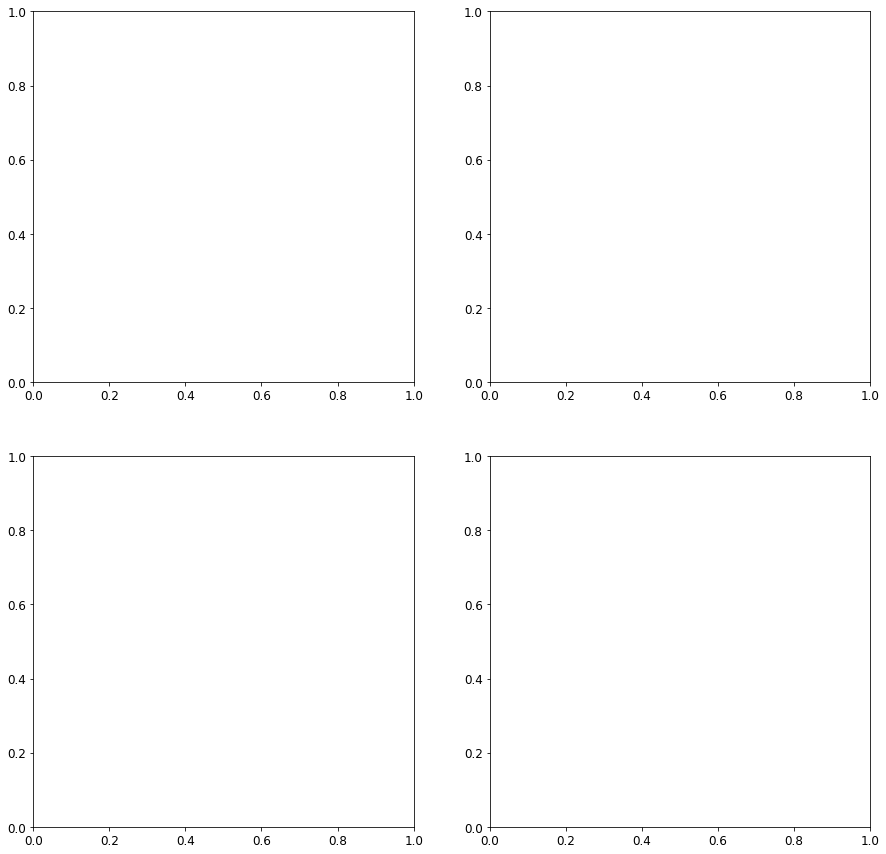

In [17]:
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fig, ax = plt.subplots(2, 2, figsize=(15,15))
# http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 0.8}
error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
data_err_opts = {'linestyle':'none', 'marker': '.', 'markersize': 10., 'color':'k', 'elinewidth': 1, 'emarker': '_'}

for i in range(2):
    for j in range(2):
        ax[i,j].set_prop_cycle(cycler(color=colors))        
        plot.plot1d(ax[i,j], to_plot[i,j], names[i,j], stack=True, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)        
        #ret = plot.plot1d(ax[0,0], data_plot, "m_J", error_opts=data_err_opts)
        ax[i,j].autoscale(axis='x', tight=True)
        ax[i,j].set_ylim(0, None)
        leg = ax[i,j].legend()
        coffee = plt.text(0., 1., u"☕", fontsize=28, horizontalalignment='left', verticalalignment='bottom', transform=ax[i,j].transAxes)
        lumi = plt.text(1., 1., r"1 fb$^{-1}$ (13 TeV)", fontsize=16, horizontalalignment='right', verticalalignment='bottom', transform=ax[i,j].transAxes)